In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from descwl_shear_sims.psfs import make_fixed_psf
from descwl_shear_sims.sim import get_se_dim
from descwl_shear_sims.sim import make_sim
from descwl_shear_sims.galaxies import FixedGalaxyCatalog, WLDeblendGalaxyCatalog
from descwl_shear_sims.layout.layout import Layout
from astropy.visualization import make_lupton_rgb

In [2]:
def create_rgb(image, bgr=[0,1,2], stretch=4, Q=4, scale=[1.0,1.0,1.0]):
    if scale is None:
        r_im = image[bgr[2]]
        g_im = image[bgr[1]]
        b_im = image[bgr[0]]
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]] * scale[0]
        g_im = image[bgr[1]] * scale[1]
        b_im = image[bgr[0]] * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)

    return rgb

In [3]:
os.environ['CATSIM_DIR'] = '/data/scratch/twhit/lsst_stack/descwl-shear-sims/notebooks/catsim' 

In [4]:
num_data = 1
ntrial = 1
seed = 42
rng = np.random.RandomState(seed)
mag = 20.0
hlr = 0.5
variable_psf = True
variation_factor = 1
psf_type = "moffat"
morph = 'exp'
pixel_scale = 0.2
coadd_dim = 2550
buff = 0
sep = 9.5
bands = ['r', 'i', 'z']
noise_factor = 1
dither = False
dither_size = 0.5
rotate = False
cosmic_rays = False
bad_columns = False
shear_setting = "vary"
density = 80
catalog_type = 'wldeblend'
select_observable = 'i_ab'
select_lower_limit = None
select_upper_limit = 27 
n_tiles_per_side = 1
star_catalog = None
star_bleeds = False

In [5]:
se_dim = get_se_dim(coadd_dim=coadd_dim, rotate=rotate)

no coadd_scale or se_scale. Assume they are the same


In [6]:
psf = make_fixed_psf(psf_type="moffat")

shear1 = shear2 = 0, fixed galaxy catalog with hex layout

In [7]:
layout = Layout(
    layout_name='hex',
    coadd_dim=coadd_dim,
    pixel_scale=pixel_scale,
    buff=buff
)

In [8]:
galaxy_catalog = FixedGalaxyCatalog(
    rng=rng,
    coadd_dim=coadd_dim,
    buff=buff,
    layout=layout,
    mag=mag,
    hlr=hlr,
    morph=morph,
    pixel_scale=pixel_scale,
    sep=sep
)

In [9]:
hex_noshear = make_sim(
    rng=rng,
    galaxy_catalog=galaxy_catalog,
    coadd_dim=coadd_dim,
    g1=0,
    g2=0,
    bands=bands,
    psf=psf,
    noise_factor=noise_factor,
    dither=dither,
    dither_size=dither_size,
    rotate=rotate,
    cosmic_rays=cosmic_rays,
    bad_columns=bad_columns,
    star_bleeds=star_bleeds,
)

In [10]:
image_hex_noshear = torch.cat((
    torch.tensor(hex_noshear['band_data']['r'][0].image.array[768:1792,768:1792]).unsqueeze(0),
    torch.tensor(hex_noshear['band_data']['i'][0].image.array[768:1792,768:1792]).unsqueeze(0),
    torch.tensor(hex_noshear['band_data']['z'][0].image.array[768:1792,768:1792]).unsqueeze(0),
), dim=0)

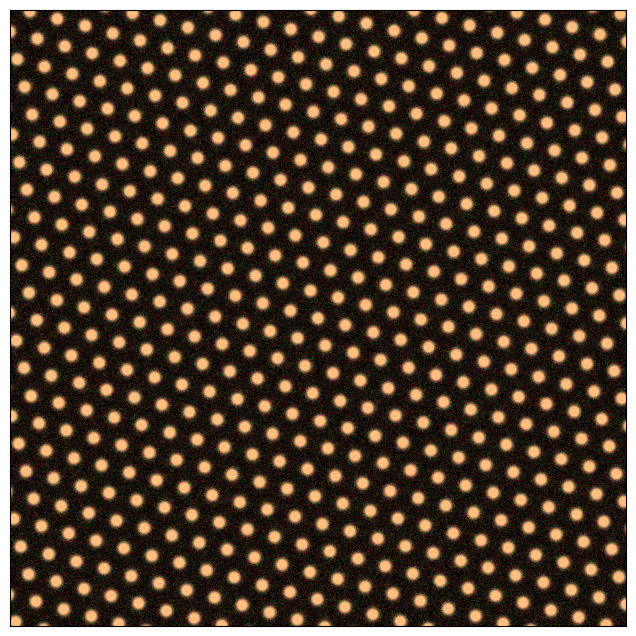

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (8,8))
_ = ax.imshow(create_rgb(image_hex_noshear, scale=[1.0,0.75,0.5]), origin = 'lower')
_ = ax.set_xticks([])
_ = ax.set_yticks([])

fig.savefig('figures/image_hex_noshear.png', dpi = 300, transparent = True, bbox_inches='tight', pad_inches = 0)

shear1 = 0.4, shear2 = -0.4, fixed galaxy catalog with hex layout

In [12]:
hex_shear = make_sim(
    rng=rng,
    galaxy_catalog=galaxy_catalog,
    coadd_dim=coadd_dim,
    g1=0.4,
    g2=-0.4,
    bands=bands,
    psf=psf,
    noise_factor=noise_factor,
    dither=dither,
    dither_size=dither_size,
    rotate=rotate,
    cosmic_rays=cosmic_rays,
    bad_columns=bad_columns,
    star_bleeds=star_bleeds,
)

In [13]:
image_hex_shear = torch.cat((
    torch.tensor(hex_shear['band_data']['r'][0].image.array[768:1792,768:1792]).unsqueeze(0),
    torch.tensor(hex_shear['band_data']['i'][0].image.array[768:1792,768:1792]).unsqueeze(0),
    torch.tensor(hex_shear['band_data']['z'][0].image.array[768:1792,768:1792]).unsqueeze(0),
), dim=0)

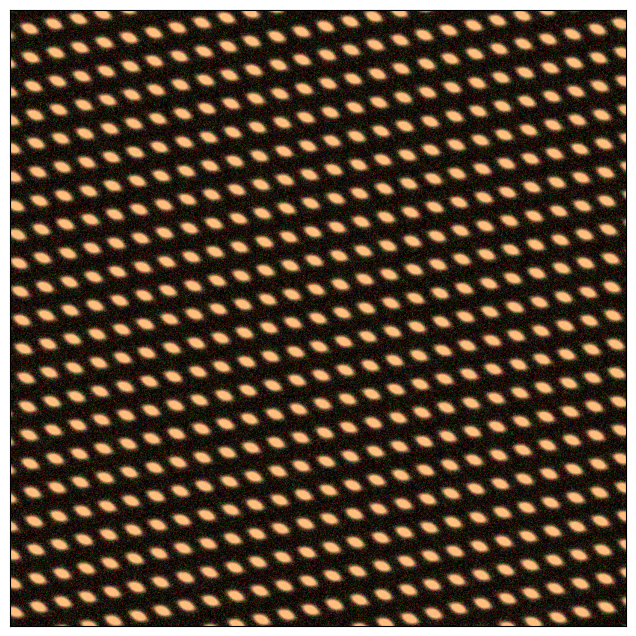

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (8,8))
_ = ax.imshow(create_rgb(image_hex_shear, scale=[1.0,0.75,0.5]), origin = 'lower')
_ = ax.set_xticks([])
_ = ax.set_yticks([])

fig.savefig('figures/image_hex_shear.png', dpi = 300, transparent = True, bbox_inches='tight', pad_inches = 0)

shear1 = 0.025, shear2 = -0.025, WeakLensingDeblending galaxy catalog with random layout

In [15]:
layout = Layout(
    layout_name='random',
    coadd_dim=coadd_dim,
    pixel_scale=pixel_scale,
    buff=buff
)

In [16]:
galaxy_catalog = WLDeblendGalaxyCatalog(
    rng=rng,
    coadd_dim=coadd_dim,
    buff=buff,
    layout=layout,
    sep=sep,
    select_observable=select_observable,
    select_lower_limit=select_lower_limit,
    select_upper_limit=select_upper_limit
)

# adjust density
galaxy_catalog.shifts_array = layout.get_shifts(rng, density=density)
num = len(galaxy_catalog.shifts_array)
galaxy_catalog.indices = galaxy_catalog.rng.randint(
    0,
    galaxy_catalog._wldeblend_cat.size,
    size=num,
)
galaxy_catalog.angles = galaxy_catalog.rng.uniform(low=0, high=360, size=num)

In [17]:
random_shear = make_sim(
    rng=rng,
    galaxy_catalog=galaxy_catalog,
    coadd_dim=coadd_dim,
    g1=0.025,
    g2=-0.025,
    bands=bands,
    psf=psf,
    noise_factor=noise_factor,
    dither=dither,
    dither_size=dither_size,
    rotate=rotate,
    cosmic_rays=cosmic_rays,
    bad_columns=bad_columns,
    star_bleeds=star_bleeds,
)

In [18]:
image_random_shear = torch.cat((
    torch.tensor(random_shear['band_data']['r'][0].image.array[768:1792,768:1792]).unsqueeze(0),
    torch.tensor(random_shear['band_data']['i'][0].image.array[768:1792,768:1792]).unsqueeze(0),
    torch.tensor(random_shear['band_data']['z'][0].image.array[768:1792,768:1792]).unsqueeze(0),
), dim=0)

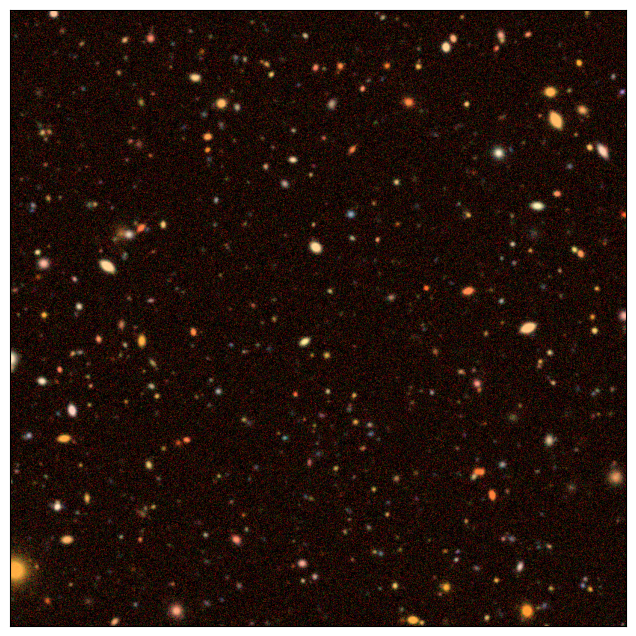

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (8,8))
_ = ax.imshow(create_rgb(image_random_shear), origin = 'lower')
_ = ax.set_xticks([])
_ = ax.set_yticks([])

fig.savefig('figures/image_random_shear.png', dpi = 300, transparent = True, bbox_inches='tight', pad_inches = 0)